# Machine Learning to classify Iris species based on its sepal and petal dimensions using Logistic regression

In [53]:
import sys
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

## Define Functions

### 1.     Function - create_label_dict
####          This function will be used to create dictionary that will be used for mapping the species (in the dataset) to number (basis vector). {'Iris-setosa':[1, 0, 0], 'Iris-versicolor':[0, 1, 0], 'Iris-virginica':[0, 0, 1]}
####          We use basis vector like mapping because the predicted o/p is ,3 shaped array
####          input is unique values of 'species' in Iris dataset   and ouput is a dictionary 

In [54]:
def create_label_dict(unique_labels):
    """
    This will generate numeric mappings for the label columns -- ex 'Iris_setosa' will be mapped as [1,0,0]
    """
    a_len = len(unique_labels)
    b_arr = []
    label_dict = {}
    ind = 0
    for i in unique_labels: 
        for j in range(a_len):
            if j == (ind):
                b_arr.append(1)
            else:
                b_arr.append(0)
        ind+=1
    
        label_dict[i]=np.array(b_arr)
        b_arr.clear()
    return label_dict

### 2.     Function - analyze_initial_dataset
####          This function is to analyze the data in the dataset - We know the min, max, mean , stddiv of each feature and plot scatter plot to                    see the classification of each species

In [55]:
def analyze_initial_dataset(dataframe, feature_columns,label_column):
    """
    Print summary of the data (Min, max, mean, stddiv)
    Plot scatterplot to show classifiction distribution of the three classes of Iris species
    """
    data = dataframe
    
    ## display summary information of the Iris dataset
    print("-------------------   Summary information of Iris Dataset   ---------------------------")
    print(data.describe())
    print(' ')
    print("---------------   End of Summary information of Iris Dataset   ------------------------")
    print(" ")
    ## this is the only place hardcoded as scatterplot will not accept bias vector [1,0,0] kind of values
    data[label_column] = data[label_column].map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})
    
    features_frame  = data.loc[0:, feature_columns]
    labels_frame = data.loc[0:,label_column]
    
    ## Plot scatter plot with x = petal length Vs y = sepal length
    ## to get a basic idea of the classification
    
    plt.scatter(features_frame['petal_length'].values,
                features_frame['sepal_length'].values,
                c=labels_frame.values,
                cmap='viridis')
    plt.title("Classification of Iris Species")
    plt.xlabel("Petal length")
    plt.ylabel("Sepal length")

### 3.    Function - create_Train_Test_dataset
####         This function will accept a filename, create mappings for Label columns,   create seperate datasets for Training and Testing with                  80/20 percent split   

In [56]:
def create_Train_Test_dataset(dataframe,label_column_name, split_fract):
    """
    Create Training and Testing Dataset
    """
    data=dataframe
    data = data.sample(frac=1).reset_index(drop=True)
    unique_values=list(data[label_column_name].unique())
    label_dict={}
    label_dict=create_label_dict(unique_values)
    data[label_column_name] = data[label_column_name].map(label_dict)
    print('Total Number of records in Iris Dataset is ',len(data))
    np.random.seed(1)
    probs = np.random.rand(len(data))
    #print(probs)
    training_data = data[probs <= split_fract]
    testing_data = data[probs > split_fract]
    #print(training_data.describe)
    training_data = training_data.reset_index(drop=True)
    testing_data= testing_data.reset_index(drop=True)
    print("Total number of records in Training Set :", len(training_data))
    print("Total number of records in Testing Set :", len(testing_data))
    print("  ")
    return training_data, testing_data

### 4. Function - get_features_labels
####     This function returns two frames with data , one of features and one of Labels,  from the given dataset

In [46]:
def get_features_labels(df, features_column_name, label_column_name):
    """
    Return Features and Labels dataframes from the given dataset
    """
    features_frame  = df.loc[0:, features_column_name]
    labels_frame = df.loc[0:,label_column_name]
    return features_frame, labels_frame   


### 5. Function -  reg_model
####     This function is the main logic/function of the model. We use "softmax" function for the prediction of the label

In [47]:
def reg_model(x, W, b):
    """
    Model for prediction
    """
    y_predicted = tf.nn.softmax(tf.matmul(x, W) + b)
    return y_predicted
    

### 6.   Function - loss
####        This function calculates the loss -- W (Weights) gets calculated based on the loss. It used tensorflow's "reduce_mean" function
####         since we are using bias vector [1,0,0] kind of mapping for labels it seems that tf.nn.softmax_cross_entropy_with_logits is not giving the best results. It will be good if the mapping was like 0 , 1, 2 for each class

In [48]:
def loss(y_predicted, y):
    """
    Calculate loss during prediction process
    """
    ##return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_predicted))
    return tf.reduce_mean(-tf.reduce_sum(y * tf.log(y_predicted), reduction_indices=[1]))


### 7. Function - optimize_loss
####     This function will use "tf.train.AdamOptimizer" to optimize the loss

In [49]:
def optimize_loss(learning_rate,total_loss):
    """
    Optimize loss
    """
    ##optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(total_loss)
    return tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

### 8. Function - calculate_accuracy
####     This function will calculate the accuracy of prediction using tf.argmax and reduce_mean functions

In [57]:
def calculate_accuracy(y, y_predicted):
    """
    Calculate accuracy of the prediction
    """
    correct_prediction = tf.equal(tf.argmax(y_predicted, 1), tf.argmax(y, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 9.   Function -  run_model
####        This is the main function to run the program and build the graph - This takes as input, 1. data file name, 2. train/test dataset split fraction, 3. List of names for all the columns in the dataset 4. list of name for all the features that will be used, 5. name for the label column, 6. Hyperparameters - Learning_rate and Epoch and Tensorboard Summary directory name

In [61]:
def run_model(fname, dsplit,column_names,feature_column_names, label_column_name, lrate, epoch_run, train_batch_size, summary_directry):
    """
    Main process to run the graph of the model in the session
    """   
    ##  Read, Analyze dataset and Create Train and Test datasets
    filename = fname
    data = pd.read_csv(filename, names=column_names)
    analyze_initial_dataset(data, feature_column_names,label_column_name)
    train_data, test_data = create_Train_Test_dataset(data,label_column_name, dsplit)
    
    ##  Create graph
    g = tf.Graph()
    with g.as_default():
        
         ##  Define Variables 
         with tf.name_scope("Global_Variables"):
               ## summary Variables
               global_step = tf.Variable(0, dtype=tf.int32, name="global_step")
               increment_step = global_step.assign_add(1)
    
               ## Variables for Predictions (Weights/slopes and Bias/error)
               W = tf.Variable(tf.zeros([4, 3]), name = "weights")
               b = tf.Variable(tf.zeros([3]), name = "bias")
               
               ## Hyperparameter Variables
               learning_rate = lrate
               epoch=epoch_run
               batch_size = train_batch_size

         ##  Define main Logic for the model  
         ##  Rest name scopes are self explanatory
         with tf.name_scope("Logistic_Regression"):
             
             with tf.name_scope("Input_Variables"):
                 x = tf.placeholder(tf.float32, shape=[None, 4], name="input_Features")
                 y = tf.placeholder(tf.float32, shape=[None,3], name="input_Labels")
             
             with tf.name_scope("Predicted_Output"):
                  y_predicted =  reg_model(x, W, b)
                  
             with tf.name_scope("Loss_and_Accuracy"):
                  total_loss  =  loss(y_predicted, y)
                  train_opt   =  optimize_loss(learning_rate,total_loss)
                  accuracy    =  calculate_accuracy(y, y_predicted)
                  
         with tf.name_scope("Summaries"):
                tf.summary.scalar('Loss_Summary', total_loss)  # Creates summary for output node
                tf.summary.scalar('Accuracy', accuracy)
                
         with tf.name_scope("Global_Ops"):
               init = tf.global_variables_initializer()
               merged_summaries = tf.summary.merge_all()
    
    ## Run the Graph - Calculate weights and Bias for optimal prediction           
    sess = tf.Session(graph=g)
    writer = tf.summary.FileWriter(summary_directry, g)
    sess.run(init)
    batch_ind=0
    last_two = epoch - 2
    print(" ")
    print("Learning Rate is:", learning_rate)
    print("epoch is:", epoch)
    print("Batch size is:", batch_size)
    print(" ")
    
    ##  Training Loop
    print("--------------------------   Begin Training  -------------------------------")
    
    for step in range(epoch):
        batch_ind = 0
      
        for batch in range(int((len(train_data.index)+1)/30)):
            start = batch_ind
            stop = batch_ind + 29
            #print('start and stop is',start,' ...',stop)
            x_features  = train_data.loc[start:stop, feature_column_names]
            ## reshape to match the input variable x and matrix multiplication with W
            x_input = x_features.values.reshape(batch_size, 4)
          
            y_labels = train_data.loc[start:stop, label_column_name]
            ## Convert to List to match matrix multiplication during the loss calculation
            y_input_arr = list(y_labels)  
            y_input = y_input_arr
          
            feed_dict={x: x_input, y: y_input}
            error, _, summary, incr_step = sess.run([total_loss, train_opt,merged_summaries, increment_step ], feed_dict=feed_dict)            
            writer.add_summary(summary, global_step=incr_step)
            batch_ind+=29
        if step%500 == 0:
             print ('Training Loss is :',error)
        if step > last_two:
             print ('Training Loss is :',error)
        
    print(" ")
    print("--------------------------   End Training  -------------------------------")
    print(" ")
    ## End of above training loop
    
    ## Perform random test
    print("-----------------   Prediction from Random Sample   ----------------------")
    test_random_dataset = [[5.1, 3.3, 1.7, 0.5, 'setosa'],
                           [5.9, 3.0, 4.2, 1.5, 'versicolor'],
                           [6.9, 3.1, 5.4, 2.1,'virginica'],
                           [6.0, 3.4, 4.5, 1.6,'versicolor'],
                           [5.7, 2.6, 3.5, 1.0,'versicolor']]
    
    for x_random_input in test_random_dataset:
         
         prediction = sess.run([tf.argmax(y_predicted, 1)], feed_dict={x: [x_random_input[0:4]]})
         ##print('prediction value is ',prediction)
         if prediction[0] == 0 :
             print("Actual flower is:", x_random_input[4],"    ----->  Predicted flower is ': Iris_setosa")
         elif prediction[0] == 1 :
             print("Actual flower is:", x_random_input[4],"    ----->  Predicted flower is ': Iris_versicolor")
         else:
             print("Actual flower is:", x_random_input[4],"    ----->  Predicted flower is ': Iris_virginica")
    
    
    print(" ")
    print("-----------------   Testing the model   ----------------------")
    x_test_accuracy_input, y_test_labels_frame = get_features_labels(test_data, feature_column_names, label_column_name)
    y_test_accuracy_input=list(y_test_labels_frame)
    
    prediction_accuracy = sess.run(accuracy, feed_dict={x: x_test_accuracy_input, y:y_test_accuracy_input})
    print("Accuracy of this Model is: ",prediction_accuracy * 100,"%") 
    
    print(" ")
    print("--- End of the Learning process --- ")
    sess.close()
    
    writer.flush()
    writer.close()
    sess.close()

### Run the program from here

TensorFlow version: 1.12.0
Python version: 3.6.8 (v3.6.8:3c6b436a57, Dec 24 2018, 02:04:31) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
 
-------------------   Summary information of Iris Dataset   ---------------------------
       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000
 
---------------   End of Summary information of Iris Dataset   ------------------------
 
Total Number of records in Iris Dataset is  150
Total number of records in Training Set : 119
Total number of records in Testing S

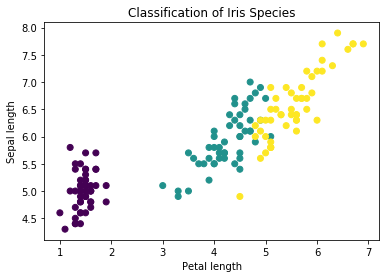

In [62]:
""" Program runs from here"""
print("TensorFlow version: {}".format(tf.__version__))
print("Python version: {}".format(sys.version))
print(' ')
data_filename = '/Users/Aadya/Documents/2018_Machine_Learning/Berkley_Tflow/HomeWork/Project/iris-species/Iris.csv'
dataset_split       = 0.8
All_column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
features_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
label_name = 'species'

##  Hyperparameters
hp_learning_rate = 0.0001
hp_epoch         = 3500
hp_batch_size = 30

summary_directory_name = './Gaigavale_P_project_graph'
run_model(data_filename, dataset_split, All_column_names,features_names, label_name, hp_learning_rate, hp_epoch, hp_batch_size, summary_directory_name)
